# Восстановление золота из руды

Чтобы повысить эффективность работы золотодобывающего предприятия, нужно построить модель, предсказывающую коэффициент восстановления золота из золотосодержащей руды. Нам предоставлены данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Подготовка данных

In [1]:
#импортируем нужные библиотеки

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#давим варнинги
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

#улучшаем качество графиков
%config InlineBackend.figure_format = 'retina'

In [2]:
#считываем файлы
try:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv',
                             index_col='date',
                             parse_dates=True)
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv',
                            index_col='date',
                            parse_dates=True)
    data = pd.read_csv('/datasets/gold_recovery_full_new.csv', 
                       index_col='date',
                       parse_dates=True)
except:
    data_train = pd.read_csv('C:\\Users\\Дмитрий\\Desktop\\Проекты Я.Практикум\\gold\\gold_recovery_train_new.csv',
                             index_col='date',
                             parse_dates=True)
    data_test = pd.read_csv('C:\\Users\\Дмитрий\\Desktop\\Проекты Я.Практикум\\gold\\gold_recovery_test_new.csv',
                            index_col='date',
                            parse_dates=True)
    data = pd.read_csv('C:\\Users\\Дмитрий\\Desktop\\Проекты Я.Практикум\\gold\\gold_recovery_full_new.csv', 
                       index_col='date',
                       parse_dates=True)
    

In [3]:
#изучаем данные
data.info()
display(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452


In [4]:
data_train.info()
display(data_train)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452


In [5]:
data_test.info()
display(data_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,-499.599127,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,-503.587739,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,-520.667442,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882


**Проверка расчетов эффективности очистки**

In [6]:
C =  data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']
recovery = (C* (F-T)) / (F* (C-T)) * 100

mae = mean_absolute_error(data_train['rougher.output.recovery'], recovery)
print(mae)

9.73512347450521e-15


Среднее абсолютное отклонение стремится к нулю. Значит, первоначальные расчеты были правильные.

In [7]:
#проверяем долю пропусков
display(data_train.isna().mean().sort_values(ascending=False))
print('Максимальная доля пропусков равна', data_train.isna().mean().max())

secondary_cleaner.output.tail_sol           0.113436
rougher.state.floatbank10_e_air             0.030815
rougher.input.floatbank11_xanthate          0.030249
primary_cleaner.output.concentrate_sol      0.020213
secondary_cleaner.state.floatbank2_a_air    0.015337
                                              ...   
rougher.state.floatbank10_d_air             0.000000
rougher.output.concentrate_au               0.000000
rougher.output.recovery                     0.000000
rougher.output.tail_pb                      0.000000
rougher.output.concentrate_ag               0.000000
Length: 86, dtype: float64

Максимальная доля пропусков равна 0.11343557848611209


In [8]:
display(data_test.isna().mean().sort_values(ascending=False))
print('Максимальная доля пропусков равна', data_test.isna().mean().max())

rougher.input.floatbank11_xanthate            0.004726
rougher.input.feed_sol                        0.003970
secondary_cleaner.state.floatbank3_a_air      0.001701
rougher.input.floatbank11_sulfate             0.001512
primary_cleaner.input.depressant              0.000945
rougher.input.floatbank10_sulfate             0.000945
primary_cleaner.input.sulfate                 0.000756
primary_cleaner.input.xanthate                0.000756
rougher.input.feed_rate                       0.000567
secondary_cleaner.state.floatbank2_a_air      0.000567
secondary_cleaner.state.floatbank2_b_air      0.000378
rougher.input.feed_size                       0.000189
secondary_cleaner.state.floatbank3_b_level    0.000000
secondary_cleaner.state.floatbank3_b_air      0.000000
rougher.state.floatbank10_f_air               0.000000
rougher.state.floatbank10_f_level             0.000000
secondary_cleaner.state.floatbank6_a_air      0.000000
secondary_cleaner.state.floatbank5_b_level    0.000000
secondary_

Максимальная доля пропусков равна 0.004725897920604915


In [9]:
display(data.isna().mean().sort_values(ascending=False))
print('Максимальная доля пропусков равна', data.isna().mean().max())

secondary_cleaner.output.tail_sol           0.089922
rougher.input.floatbank11_xanthate          0.023304
rougher.state.floatbank10_e_air             0.022429
primary_cleaner.output.concentrate_sol      0.019034
secondary_cleaner.state.floatbank2_a_air    0.011317
                                              ...   
rougher.state.floatbank10_d_level           0.000000
rougher.state.floatbank10_d_air             0.000000
rougher.output.tail_sol                     0.000000
rougher.output.tail_au                      0.000000
rougher.output.concentrate_ag               0.000000
Length: 86, dtype: float64

Максимальная доля пропусков равна 0.08992232110705284


Значения в строках, стоящих рядом, близки. Поэтому заменяем пропуски значением из предыдущей строки.

In [10]:
#заполняем пропуски предыдущим значением
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')
data = data.fillna(method='ffill')

In [11]:
#добавляем в тестовую выборку целевые признаки
data_full_merged = data[['rougher.output.recovery', 'final.output.recovery']]
data_test = data_test.merge(data_full_merged, on='date', how='left')

In [12]:
#удаляем из обучающей выборки лишние столбцы
columns = set(data_train.columns) - set(data_test.columns)
display(columns)
data_train = data_train.drop(columns, axis=1)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleane

**Выводы о предобработке**

* В каждой из таблиц доля пропусков в стобцах составляет не более 3%. Исключением является столбец `secondary_cleaner.output.tail_sol` в исходном датафрейме, - 9% пропусков. Вероятно, данные по этому процессу еще не были получены. С пропусками обучить модель не получится. Анализируя данные, видно, что стоящие рядом значения практически одинаковые, поэтому заменили пропуски предыдущим значением.

* Обучающая и тестовая выборки содержат разное количество столбцов. В обучающей выборке содержатся столбцы, указывающие на выходные данные процесса (`output`) и рассчетные характеристики (`calculation`). Наша задача - прогнозировать результаты на основе входных данных, поэтому столбцы с выходными данными удаляем из обучающей выборки (но добавляем в тестовую выборку данные о `recovery`, т.к. это - целевые признаки).

## Анализ данных

### Изменение концентраций Au, Ag, Pb на разных этапах очистки

#### Au

In [13]:
#создаем функцию для построения гистограмм
def hist_metal(raw, rougher, primary, final, name):
    plt.figure(figsize=(12, 7))
    plt.hist(raw, bins=70, alpha=0.5, label='Исходное сырьё')
    plt.hist(rougher, bins=70, alpha=0.5, label='После флотации')
    plt.hist(primary, bins=70, alpha=0.5, label='После первичной очистки')
    plt.hist(final, bins=70, alpha=0.5, label='Финальный концентрат')
    plt.title(name)
    plt.xlabel('Концентрация, %')
    plt.ylabel('Частота')
    plt.legend()
    plt.show()

In [14]:
def bar_metal(raw, rougher, primary, final, name):
    metal = data[[raw, rougher, primary, final]]
    metal.columns = ['Сырье', 'Флотация', 'Очистка 1', 'Очистка 2']
    metal.median().plot(kind='bar')
    plt.grid(True)
    plt.title(name)
    plt.ylabel('Концентрация, %')
    plt.show()
    display(metal.describe())

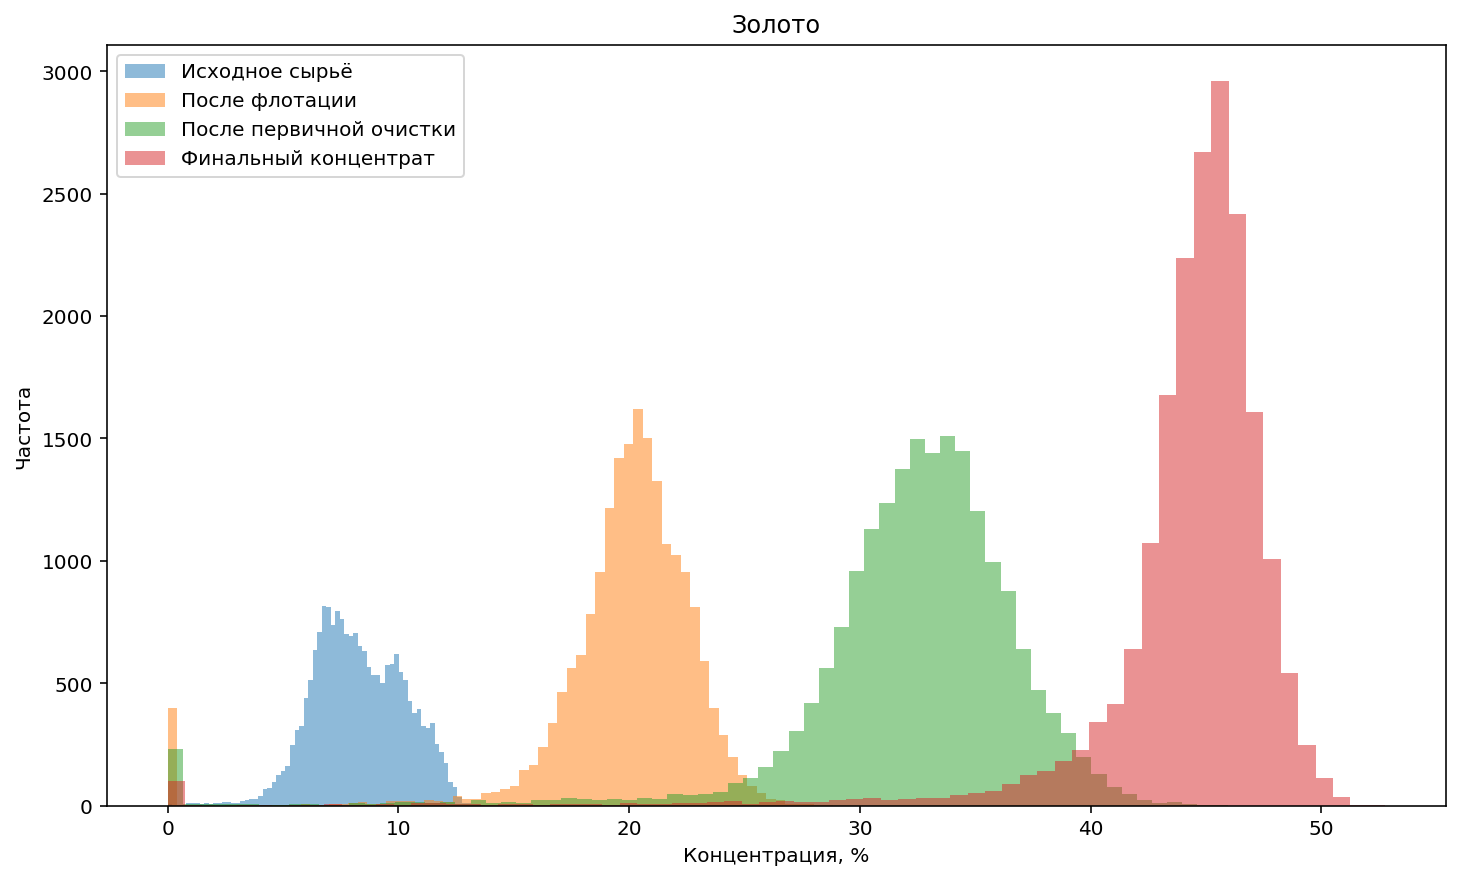

In [15]:
hist_metal(data['rougher.input.feed_au'],
           data['rougher.output.concentrate_au'],
           data['primary_cleaner.output.concentrate_au'],
           data['final.output.concentrate_au'],
          'Золото')

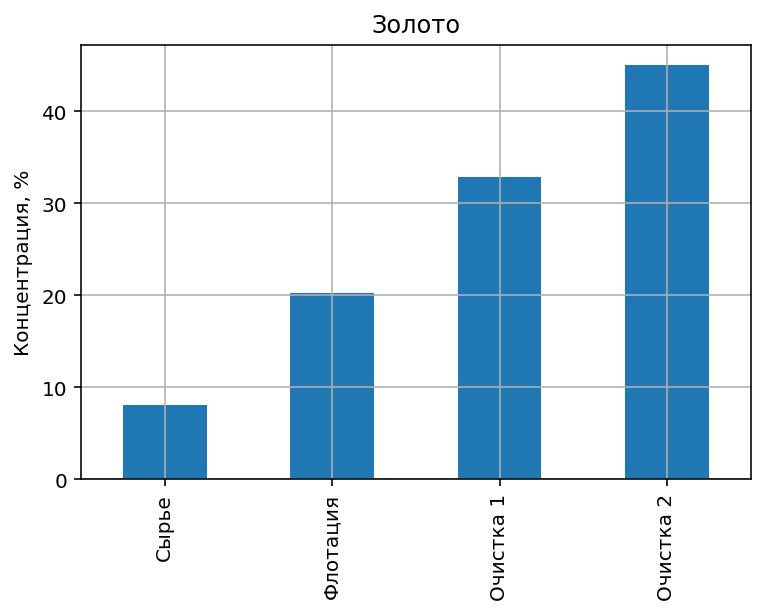

,Сырье,Флотация,Очистка 1,Очистка 2
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,8.266097,19.772000,32.119400,44.076513
std,1.955092,3.753600,5.627611,5.129784
min,0.010000,0.000000,0.000000,0.000000
25%,6.854384,18.802523,30.463140,43.402215
50%,8.125839,20.280214,32.841295,45.011244
75%,9.769917,21.717843,35.048006,46.275313
max,13.731330,28.824507,45.933934,52.756638


In [16]:
bar_metal('rougher.input.feed_au',
          'rougher.output.concentrate_au',
          'primary_cleaner.output.concentrate_au',
          'final.output.concentrate_au',
          'Золото')

#### Ag

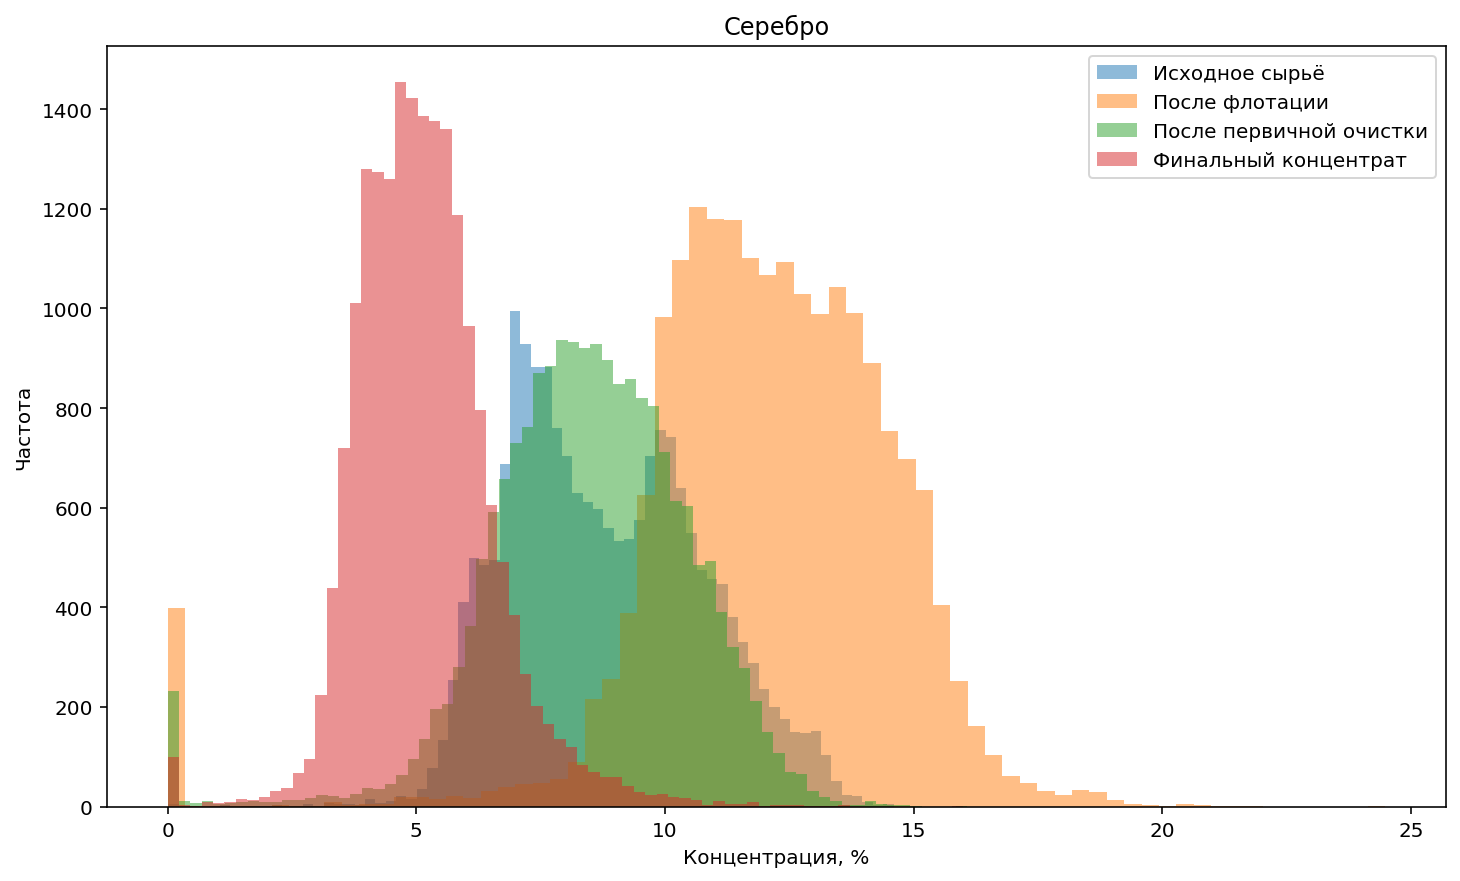

In [17]:
hist_metal(data['rougher.input.feed_ag'],
           data['rougher.output.concentrate_ag'],
           data['primary_cleaner.output.concentrate_ag'],
           data['final.output.concentrate_ag'],
          'Серебро')

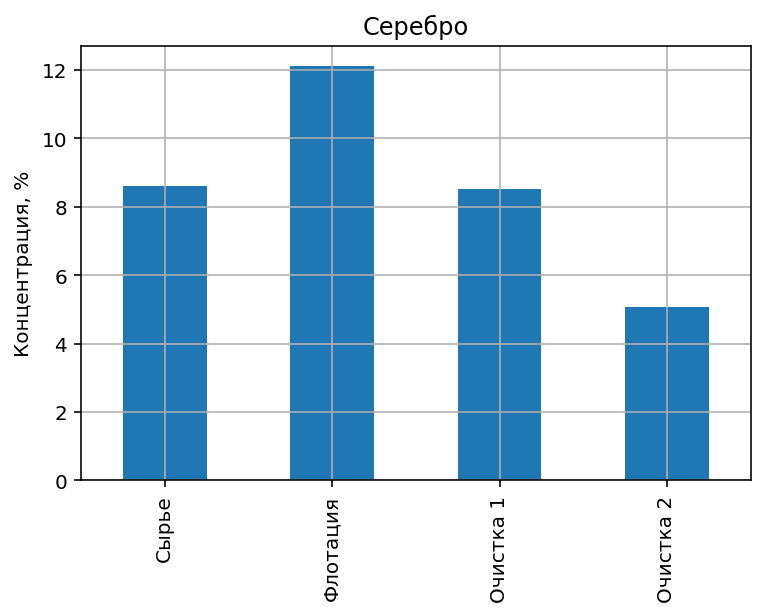

,Сырье,Флотация,Очистка 1,Очистка 2
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,8.794927,11.994759,8.442408,5.168387
std,1.936847,2.733862,2.054465,1.372362
min,0.010000,0.000000,0.000000,0.000000
25%,7.237967,10.628337,7.263288,4.251000
50%,8.593574,12.098115,8.507298,5.066039
75%,10.213771,13.736996,9.809001,5.895401
max,14.596026,24.480271,16.081632,16.001945


In [18]:
bar_metal('rougher.input.feed_ag',
          'rougher.output.concentrate_ag',
          'primary_cleaner.output.concentrate_ag',
          'final.output.concentrate_ag',
          'Серебро')

#### Pb

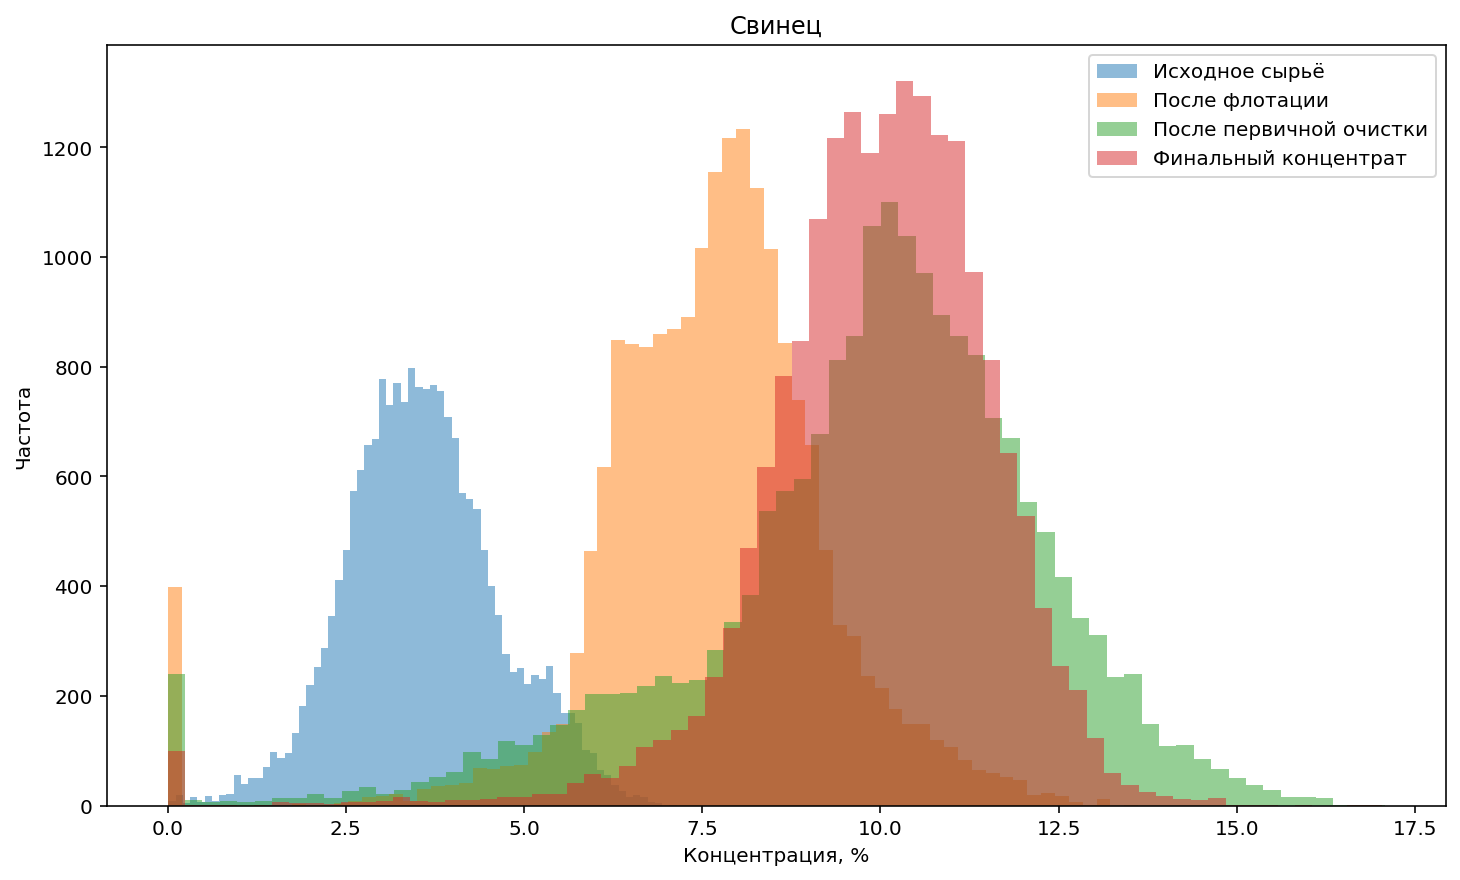

In [19]:
hist_metal(data['rougher.input.feed_pb'],
           data['rougher.output.concentrate_pb'],
           data['primary_cleaner.output.concentrate_pb'],
           data['final.output.concentrate_pb'],
          'Свинец')

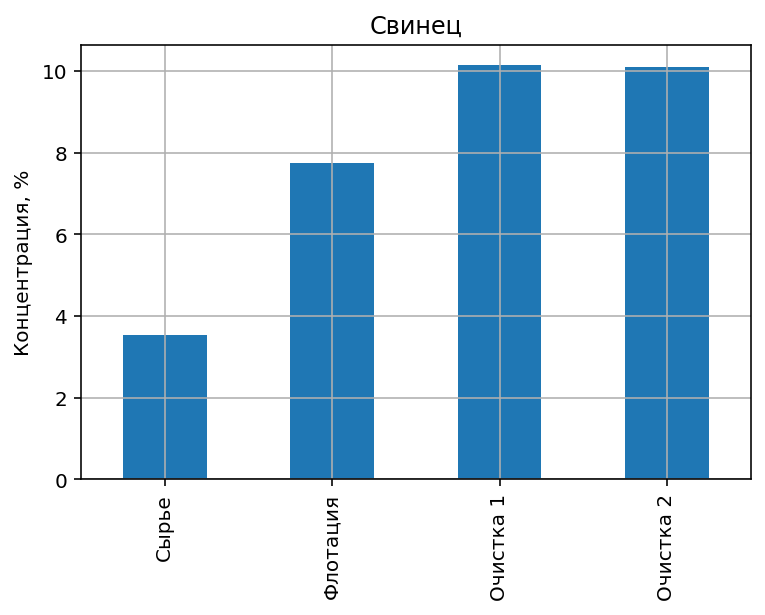

,Сырье,Флотация,Очистка 1,Очистка 2
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,3.585096,7.606272,9.810317,9.978821
std,1.062972,1.796757,2.572253,1.669228
min,0.010000,0.000000,0.000000,0.000000
25%,2.872178,6.725987,8.676500,9.137225
50%,3.528235,7.742580,10.142270,10.102264
75%,4.241005,8.565199,11.416298,11.035644
max,7.142594,13.617072,17.081278,17.031899


In [20]:
bar_metal('rougher.input.feed_pb',
          'rougher.output.concentrate_pb',
          'primary_cleaner.output.concentrate_pb',
          'final.output.concentrate_pb',
          'Свинец')

#### Выводы

* После каждого этапа очистки содержание золота в концентрате линейно возрастает. По мере очистки концентрация возрастает от 8 до 45%.

* Концентрация серебра после флотации возрастает с 8.6% до 12.1% (видимо, флотация направлена на очистку от других веществ). На следующих этапах содержание серебра падает и в итоге достигает 5%. 

* Концентрация свинца после флотации и первой очистки возрастает до примерно 10.1%. После второй очистки она не меняется. Видимо, данные способы очистки не предусмотрены для удаления свинца.

### Распределение размеров гранул

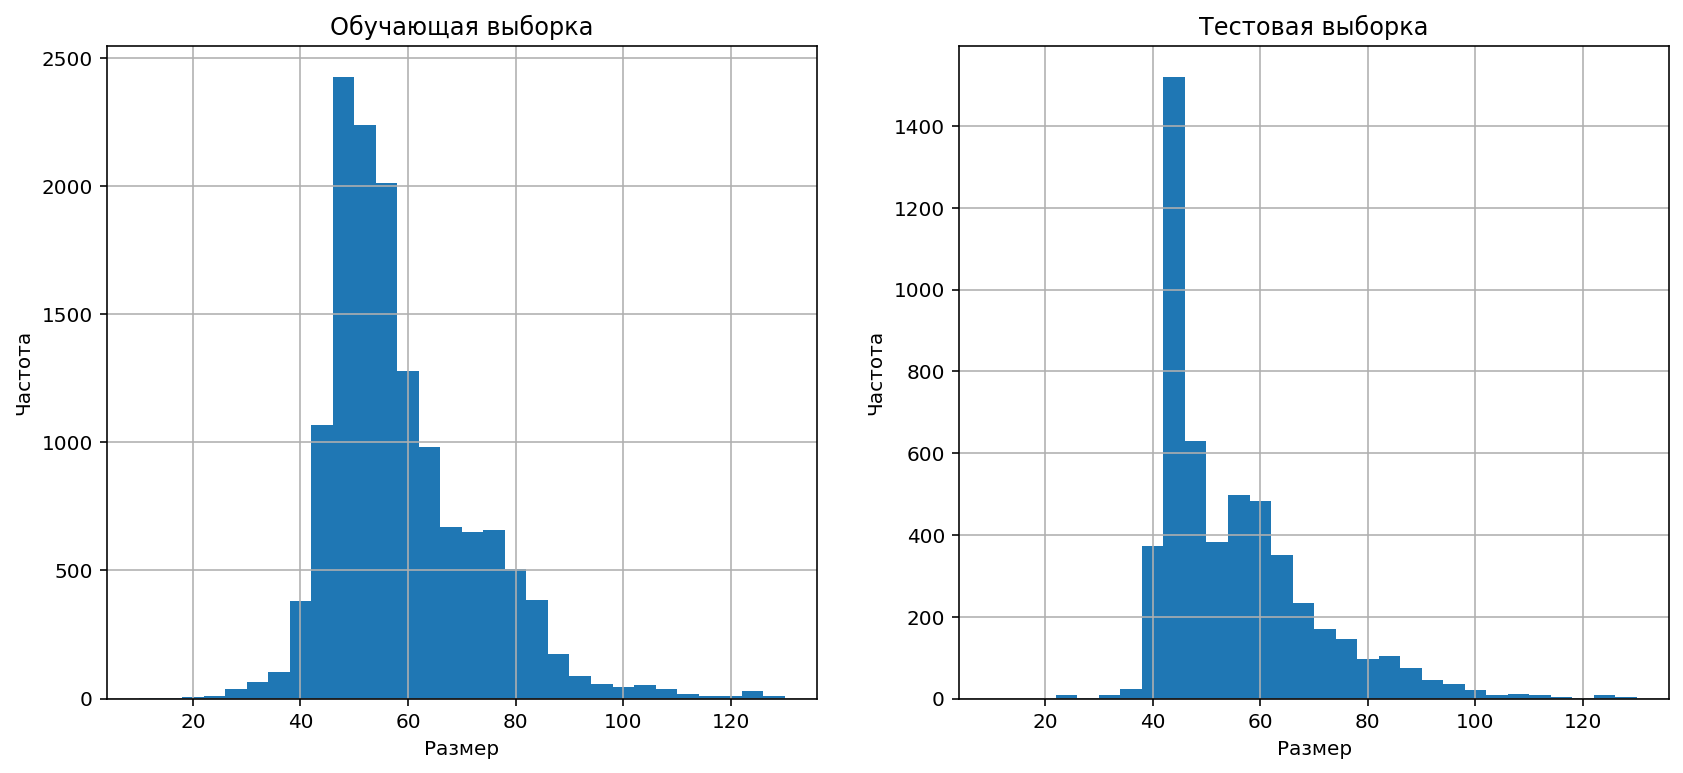

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.hist(data_train['rougher.input.feed_size'], range=(10,130), bins=30)
ax1.grid(True)
ax1.set_title('Обучающая выборка')
ax1.set_xlabel('Размер')
ax1.set_ylabel('Частота')

ax2.hist(data_test['rougher.input.feed_size'],  range=(10,130), bins=30)
ax2.grid(True)
ax2.set_title('Тестовая выборка')
ax2.set_xlabel('Размер')
ax2.set_ylabel('Частота')
plt.show()

**Вывод**

Выборки имеют похожее распределение, поэтому оставляем их.

### Исследование суммарной концентрации веществ

In [22]:
#суммируем концентрации веществ в отдельных столбцах
data['raw'] = (data['rougher.input.feed_ag'] + 
               data['rougher.input.feed_pb'] + 
               data['rougher.input.feed_sol'] + 
               data['rougher.input.feed_au'])

data['rougher'] = (data['rougher.output.concentrate_ag'] + 
                   data['rougher.output.concentrate_pb'] +
                   data['rougher.output.concentrate_sol'] +
                   data['rougher.output.concentrate_au'])

data['final'] = (data['final.output.concentrate_ag'] + 
                 data['final.output.concentrate_pb'] +
                 data['final.output.concentrate_sol'] +
                 data['final.output.concentrate_au'])
display(data)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,raw,rougher,final
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,51.680034,66.424950,63.644396
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,50.659114,67.012710,63.957723
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,50.609929,66.103793,64.311180
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,51.061546,65.752751,63.573449
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,47.859163,65.908382,64.004667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428,53.415050,70.781325,68.098589
2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608,53.696482,70.539603,68.274362
2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452,54.589604,55.376330,68.226068


#### Сырье

In [23]:
def concentration(raw, rougher, final):
    plt.figure(figsize=(12, 7))
    plt.hist(raw, bins=70, alpha=0.5, label='Исходное сырьё')
    plt.hist(rougher, bins=70, alpha=0.5, label='Черновой концентрат')
    plt.hist(final, bins=70, alpha=0.5, label='Финальный концентрат')
    plt.title('Суммарная концентрация веществ')
    plt.xlabel('Концентрация, %')
    plt.ylabel('Частота')
    plt.legend()
    plt.xlim(30,100)
    plt.show()
    display(raw.describe())
    display(rougher.describe())
    display(final.describe())

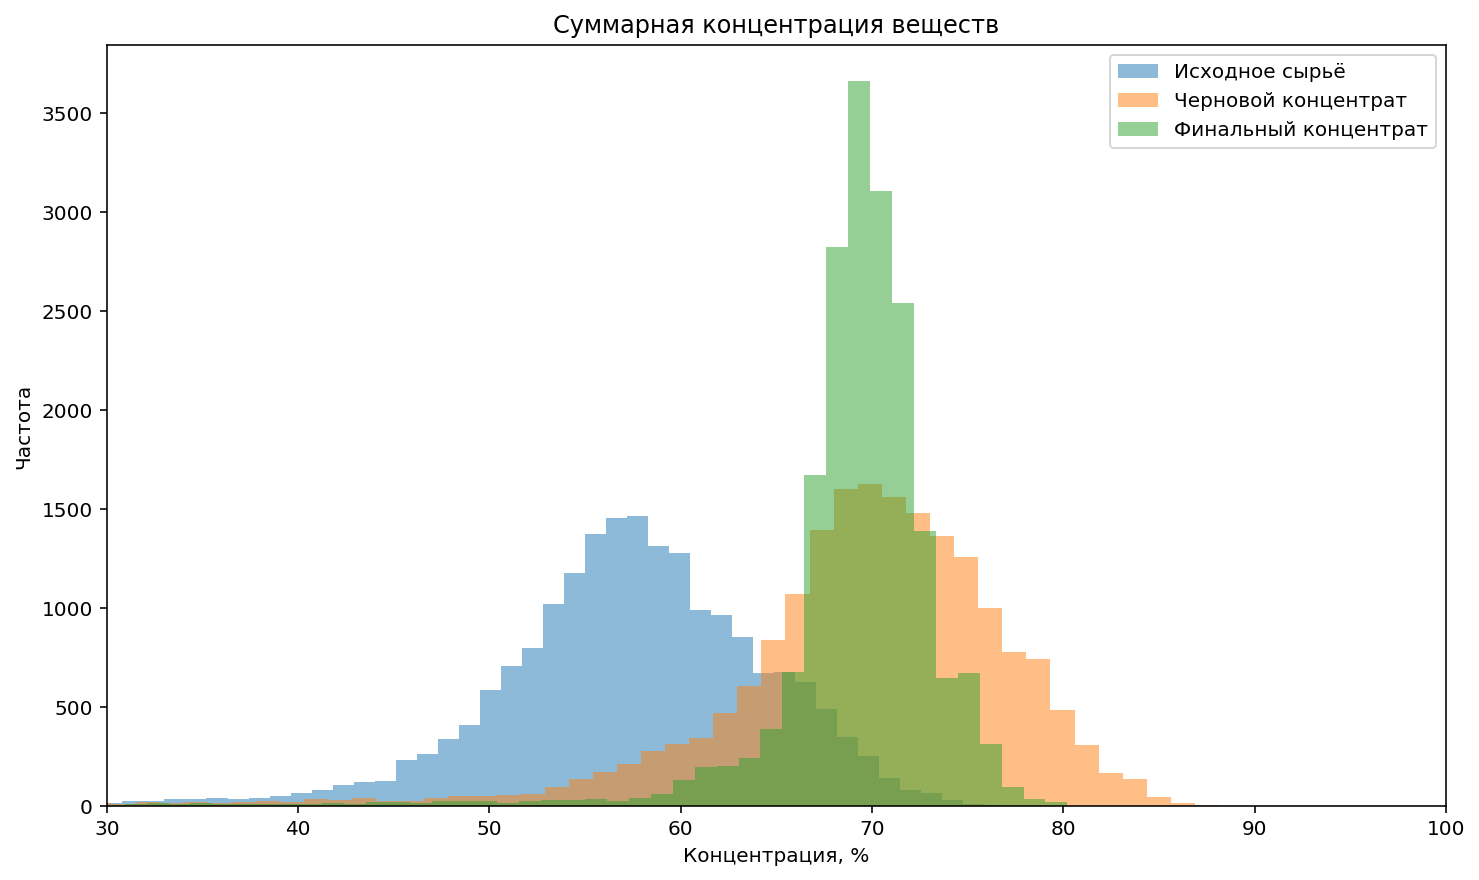

count    19439.000000
mean        57.320789
std          7.212680
min          0.040000
25%         53.557679
50%         57.594391
75%         61.953459
max         76.978947
Name: raw, dtype: float64

count    19439.000000
mean        68.170865
std         12.491279
min          0.000000
25%         66.012495
50%         70.181495
75%         74.356904
max         88.140119
Name: rougher, dtype: float64

count    19439.000000
mean        68.653624
std          7.427536
min          0.000000
25%         67.932362
50%         69.598444
75%         71.368472
max         80.210644
Name: final, dtype: float64

In [24]:
concentration(data['raw'], data['rougher'], data['final'])

В данных по черновому и финальному концентратам присутствуют выбросы (нулевые значения). Фильтруем их.

In [25]:
#отфильтровыаем выбросы
data = data.query('rougher > 0 and final > 0')

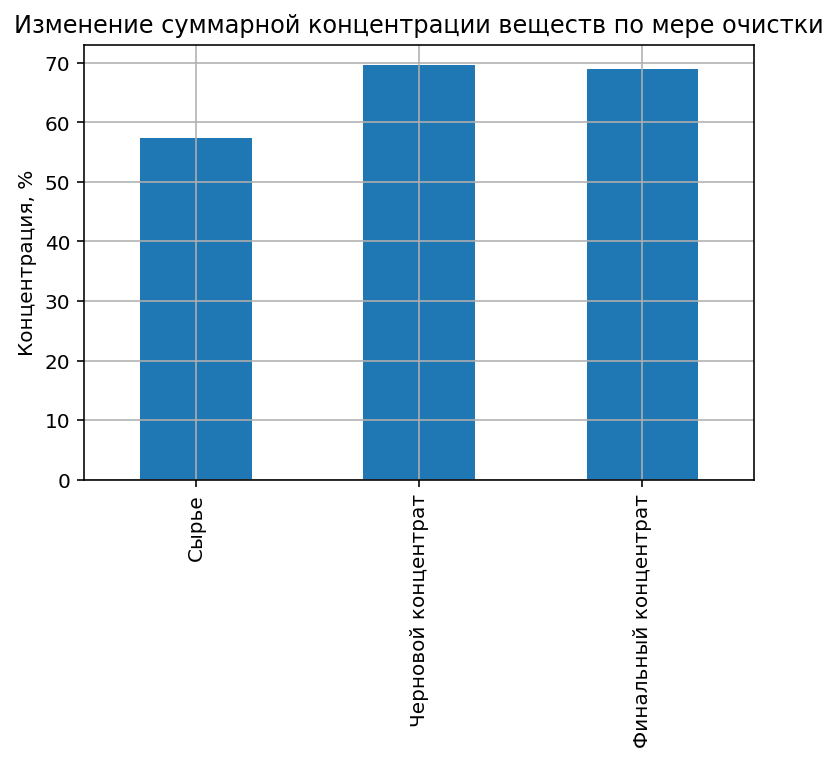

In [26]:
data_concentration = data[['raw', 'rougher', 'final']]
data_concentration.columns = ['Сырье', 'Черновой концентрат', 'Финальный концентрат']
data_concentration.mean().plot(kind='bar')
plt.grid(True)
plt.title('Изменение суммарной концентрации веществ по мере очистки')
plt.ylabel('Концентрация, %')
plt.show()

**Вывод**

Суммарная концентрация веществ (золото, серебро, свинец, коллоид) после флотации возрастает с 57 до 70%. После прохождения следующих этапов очистки концентрация остается неизменной или незначительно снижается.

## Модель

In [27]:
#создаем функцию подсчета sMAPE
def smape(target_actual, target_predictions):
    numerator = np.abs(target_actual - target_predictions)
    denominator = (np.abs(target_actual) + np.abs(target_predictions)) / 2 
    return 1 / len(target_actual) * np.sum(numerator / denominator) * 100 

In [28]:
#создаем оцениватель моделей
smape_score = make_scorer(smape, greater_is_better=False)

In [29]:
#разделяем признаки и целевой признак
features_train = data_train.drop(columns=['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_rougher = data_train['rougher.output.recovery']
target_train_final = data_train[ 'final.output.recovery']

In [30]:
features_test = data_test.drop(columns=['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_rougher = data_test['rougher.output.recovery']
target_test_final = data_test['final.output.recovery']

In [31]:
#масштабируем признаки
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### Линейная регрессия

In [32]:
model_lr = LinearRegression()
rougher_smape = cross_val_score(model_lr, features_train, target_train_rougher, scoring = smape_score, cv=5)
final_smape = cross_val_score(model_lr, features_train, target_train_final, scoring = smape_score, cv=5)
res = abs(0.25*rougher_smape.mean() + 0.75*final_smape.mean())
print('rougher_smape', abs(rougher_smape).mean())
print('final_smape', abs(final_smape).mean())
print(f'Итоговый sMAPE: {res}')

rougher_smape 12.80248345848199
final_smape 12.24530032030226
Итоговый sMAPE: 12.38459610484719


* При использовании линейной регрессии sMAPE = 12.3846

### Дерево решений

In [33]:
model_dt = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth': range(1,11,1)}
grid_rougher_dt = GridSearchCV(model_dt, param_grid=parameters, scoring=smape_score, n_jobs=-1, cv=5)
grid_final_dt = GridSearchCV(model_dt, param_grid=parameters, scoring=smape_score, n_jobs=-1, cv=5)

grid_rougher_dt.fit(features_train, target_train_rougher)
grid_final_dt.fit(features_train, target_train_final)

print(grid_rougher_dt.best_params_)
print(grid_final_dt.best_params_)

print(abs(grid_rougher_dt.best_score_))
print(abs(grid_final_dt.best_score_))
final_smape = 0.25*abs(grid_rougher_dt.best_score_) + 0.75*abs(grid_final_dt.best_score_)
print(f'Итоговый sMAPE: {final_smape}')

{'max_depth': 4}
{'max_depth': 3}
11.579887512182543
10.806104806167777
Итоговый sMAPE: 10.999550482671468


Оптимальные гиперпараметры для дерева решений:
* Для предсказания recovery чернового концентрата: глубина 4. 
* Для предсказания recovery финального концентрата: глубина 3. 
* Итоговый sMAPE = 11.0000

### Случайный лес

In [34]:
model_rf = RandomForestRegressor(random_state=12345)
parameters = {'max_depth': range(1,11,1), 'n_estimators' : range(1,21,1)}
grid_rougher_rf = GridSearchCV(model_rf, param_grid=parameters, scoring=smape_score, n_jobs=-1, cv=5)
grid_final_rf = GridSearchCV(model_rf, param_grid=parameters, scoring=smape_score, n_jobs=-1, cv=5)

grid_rougher_rf.fit(features_train, target_train_rougher)
grid_final_rf.fit(features_train, target_train_final)

print(grid_rougher_rf.best_params_)
print(grid_final_rf.best_params_)

print(abs(grid_rougher_rf.best_score_))
print(abs(grid_final_rf.best_score_))
final_smape = 0.25*abs(grid_rougher_rf.best_score_) + 0.75*abs(grid_final_rf.best_score_)
print(f'Итоговый sMAPE: {final_smape}')

{'max_depth': 6, 'n_estimators': 19}
{'max_depth': 5, 'n_estimators': 6}
10.894350058020649
10.083205174521211
Итоговый sMAPE: 10.28599139539607


Оптимальные гиперпараметры для случайного леса:
* Для предсказания recovery чернового концентрата: 19 деревьев, глубина 6. 
* Для предсказания recovery финального концентрата: 6 деревьев, глубина 5. 
* Итоговый sMAPE = 10.2860

### Вывод

Наибольшую точность показала модель случайного леса, ее и будем использовать в финальном тестировании.

## Тестирование модели

In [35]:
model_rougher = RandomForestRegressor(random_state=12345, n_estimators=19, max_depth=6)
model_rougher.fit(features_train, target_train_rougher)
prediction_rougher = model_rougher.predict(features_test)
smape_rougher = smape(target_test_rougher,prediction_rougher)

model_final = RandomForestRegressor(random_state=12345, n_estimators=6, max_depth=5)
model_final.fit(features_train, target_train_final)
prediction_final = model_final.predict(features_test)
smape_final = smape(target_test_final,prediction_final)

smape = 0.25*abs(smape_rougher) + 0.75*abs(smape_final)

print(smape_rougher)
print(smape_final)
print(f'Итоговый sMAPE: {smape}')

10.326960046366555
10.375175052418992
Итоговый sMAPE: 10.363121300905883


### Вывод


**Что было сделано:**
1) Проверили правильность расчетов recovery. 

2) Заполнили пропуски предыдущими значениями.

3) Удалили из обучающей выборки признаки, которые могли снизить точность модели.

4) Проанализировали изменение концентраций металлов по мере очистки.

5) Сравнили распределения размеров гранул в обучающей и тестовой выборках. Они оказались идентичны.

6) Проанализировали суммарные концентрации металлов и коллоида в сырье, черновом концентрате и финальном концентрате.

7) Отфильтровали данные от нулевых значений.

8) Обучили, подобрали гиперпараметры и проверили кросс-валидацией модели линейной регрессии, дерева решений и случайного леса.
Оценивали модель с помощью sMAPE.

9) Протестировали лучшую модель (случайного леса) на тестовой выборке.

**Результаты**

На обучающей выборке лучший результат (sMAPE = 10.2860) показала модель случайного леса со следующими параметрами:
* Черновой концентрат: 19 деревьев, глубина 6
* Финальный концентрат: 6 деревьев, глубина 5.

При тестировании модели значение sMAPE повысилось, но незначительно (sMAPE = 10.3631). Это значит, что модель не переобучилась и справляется с поставленной задачей.